In [2]:
import json
from collections import Counter
import bz2
import regex
import re
from tqdm import tqdm
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from pymystem3 import Mystem
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=4, use_memory_fs=True, progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
import pandas as pd
import numpy as np
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [4]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
* существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

Посчитайте количество отзывов в разных городах и на разные банки

In [5]:
responses_frame = pd.DataFrame(responses)
responses_frame.head(3)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN


In [6]:
responses_frame.city.value_counts()

г. Москва                         55354
г. Санкт-Петербург                14342
г. Екатеринбург                    2337
г. Новосибирск                     2300
г. Нижний Новгород                 1976
                                  ...  
г. ст-ца Ессентукская                 1
г. Северск (Томская область)          1
г. Балахта (Красноярский край)        1
г. Москва-Сергиев Посад               1
г. от МСК 300 км                      1
Name: city, Length: 5823, dtype: int64

In [7]:
responses_frame.bank_name.value_counts()

Сбербанк России          26327
Альфа-Банк               10224
ВТБ 24                    8185
Русский Стандарт          7943
Хоум Кредит Банк          7549
                         ...  
ИНГ Банк                     1
Курган                       1
Мой Банк. Новосибирск        1
Прайм Финанс                 1
Радиан                       1
Name: bank_name, Length: 670, dtype: int64

Постройте гистограмы длин слов в символах и в словах

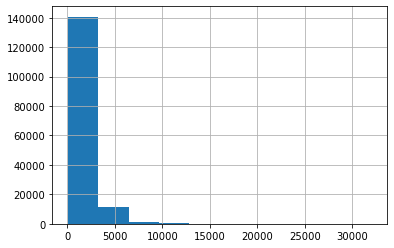

In [8]:
responses_frame.text.str.len().hist();

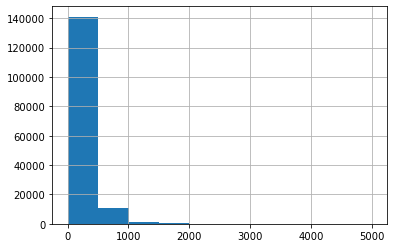

In [9]:
responses_frame.text.str.split().str.len().hist();

Найдите 10 самых частых:

слов

слов без стоп-слов

лемм

существительных


In [10]:
regex = re.compile("[А-Яа-я]+")
def words_only(text, regex=regex):
    return " ".join(regex.findall(text))

corp_ = responses_frame.text.str.lower()
corp_ = corp_.parallel_apply(words_only)

In [11]:
corp = corp_.str.split().tolist()

In [12]:
corpus = []

for sublist in tqdm(corp):
    for item in sublist:
        corpus.append(item)

corpus[:5]

['добрый', 'день', 'я', 'не', 'являюсь']

In [13]:
pd.DataFrame(Counter(corpus).items(), columns=['Word', 'Count']).sort_values('Count', ascending=False)[:10]

,Word,Count
52,в,1330550
7,и,1058997
3,не,855335
38,на,707935
72,что,640057
2,я,577500
21,с,464037
9,по,372769
78,мне,320958
6,банка,275906


In [14]:
from nltk.corpus import stopwords
mystopwords = stopwords.words('russian')+ ['это', 'наш' , 'тыс', 'млн', 
                                           'млрд', 'также',  'т', 'д', 'г',
                                           'который', 'весь',
                                          ]


print(mystopwords)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [15]:
corpus_unstop = [token for token in tqdm(corpus) if not token in mystopwords]
pd.DataFrame(Counter(corpus_unstop).items(), columns=['Word', 'Count']).sort_values('Count', ascending=False)[:10]

,Word,Count
4,банка,275906
111,банк,215426
389,деньги,131201
148,карту,105829
133,карты,101821
298,кредит,81136
1,день,76552
300,банке,72169
117,заявление,70423
562,очень,66824


In [16]:
m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "
corpus_lemmatized = pd.DataFrame(corp_).text.parallel_apply(lemmatize)
corpus_lemmatized[:5]

0    добрый день я не являться клиент банк и поручи...
1    добрый день являться держатель зарплатной карт...
2    здравствовать дублировать свой заявление от в ...
3    добрый день я открывать расчетный счет в сберб...
4    г взять кредит в ваш банк заявлять я сумма быт...
Name: text, dtype: object

In [17]:
corpus_lemmatized = corpus_lemmatized.str.split().tolist()
corpus_lemm = []

for sublist in tqdm(corpus_lemmatized):
    for item in sublist:
        corpus_lemm.append(item)

corpus_lemm[:5]

['добрый', 'день', 'я', 'не', 'являться']

In [18]:
corpus_lemm = [token for token in tqdm(corpus_lemm) if not token in mystopwords]
counts_lemm = pd.DataFrame(Counter(corpus_lemm).items(), columns=['Word', 'Count']).sort_values('Count', ascending=False).reset_index(drop=True)
counts_lemm[:10]

,Word,Count
0,банк,621048
1,карта,334998
2,деньги,179734
3,день,173065
4,кредит,156177
5,отделение,144050
6,клиент,136892
7,сотрудник,134168
8,счет,126894
9,мочь,126310


In [19]:
corpus_lemm[:5]

['добрый', 'день', 'являться', 'клиент', 'банк']

In [20]:
def is_noun(word):
    anz = m.analyze(str(word))[0]['analysis']

    if anz:
        return anz[0]['gr'].startswith('S') 
    else:
        return None

In [21]:
# мочь - существительное женского рода
m.analyze('мочь')

[{'analysis': [{'lex': 'мочь',
    'wt': 0.7298592527,
    'gr': 'S,жен,неод=(вин,ед|им,ед)'}],
  'text': 'мочь'},
 {'text': '\n'}]

In [22]:
counts_lemm['is_noun'] = counts_lemm.Word.apply(is_noun)
counts_lemm[counts_lemm.is_noun == True].iloc[:, :2].head(20)

,Word,Count
0,банк,621048
1,карта,334998
2,деньги,179734
3,день,173065
4,кредит,156177
5,отделение,144050
6,клиент,136892
7,сотрудник,134168
8,счет,126894
9,мочь,126310


In [23]:
counts_lemm_noun = counts_lemm[counts_lemm.is_noun == True].iloc[:, :2].head(20)
word_freq = dict(zip(counts_lemm_noun['Word'].tolist(), counts_lemm_noun['Count'].tolist()))

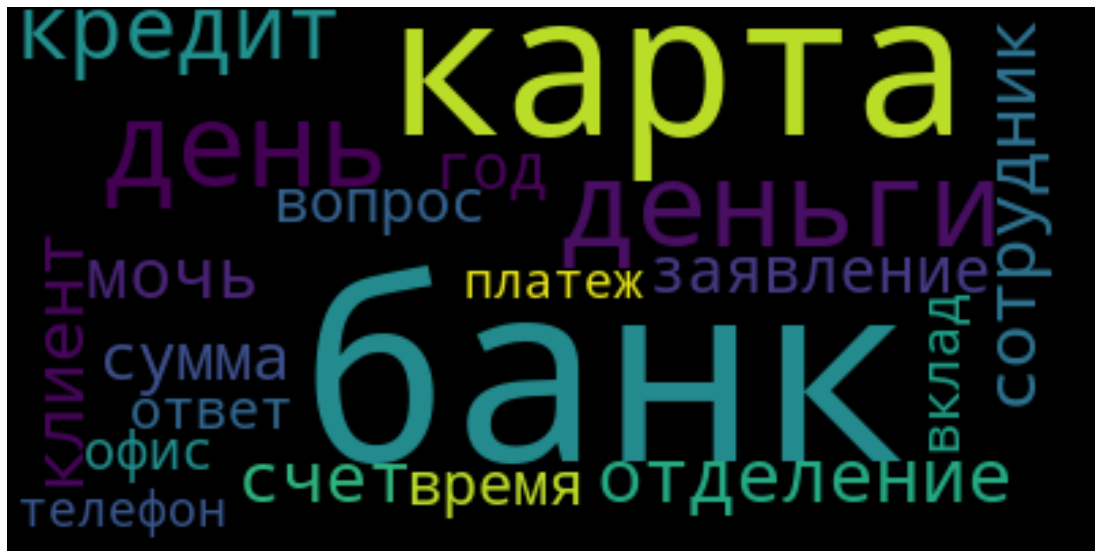

In [24]:
wd = WordCloud(background_color = 'black')
wd.generate_from_frequencies(dict(word_freq))
plt.figure(figsize=(20,10))
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()responses_frame = pd.read_csv('responses_frame.csv')
responses_frame.head(3)

Постройте кривые Ципфа и Хипса

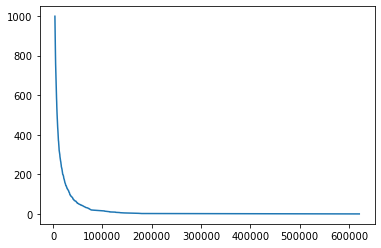

In [25]:
fig, ax = plt.subplots()
ax.plot(counts_lemm.Count[:1000], range(1000))
plt.show()

In [26]:
def del_stopwords(text):
    return [token for token in text if not token in mystopwords]

responses_frame['lemmatize_text'] = pd.Series(corpus_lemmatized).apply(del_stopwords)

In [27]:
n_types = [0]
n_tokens = [0]
tokens = []
for row in tqdm(responses_frame['lemmatize_text'][:]):
    tokens += row
    tokens = list(set(tokens)) #pd.Series(tokens).drop_duplicates().tolist()
    n_tokens.append(len(row) + n_tokens[-1])
    n_types.append(len(tokens))
#n_tokens, n_types

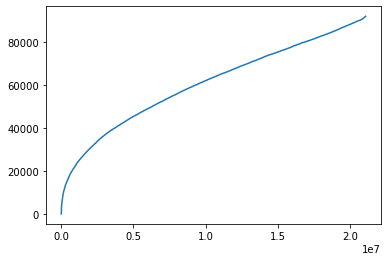

In [28]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_types)
plt.show()

Ответьте на следующие вопросы:

какое слово встречается чаще, "сотрудник" или "клиент"?

сколько раз встречается слова "мошенничество" и "доверие"?


In [29]:
counts_lemm[counts_lemm.Word.isin(["сотрудник", "клиент", "мошенничество", "доверие"])]

,Word,Count,is_noun
6,клиент,136892,True
7,сотрудник,134168,True
1068,мошенничество,3244,True
1455,доверие,2108,True


In [3]:
#responses_frame.to_csv('responses_frame.csv')
responses_frame = pd.read_csv('responses_frame.csv')
responses_frame.head(3)

,Unnamed: 0,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,lemmatize_text
0,0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,"['добрый', 'день', 'являться', 'клиент', 'банк..."
1,1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN,"['добрый', 'день', 'являться', 'держатель', 'з..."
2,2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,"['здравствовать', 'дублировать', 'свой', 'заяв..."


В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. 

Используйте меру 𝑡𝑓−𝑖𝑑𝑓, для того, чтобы найти ключевые слова и биграмы

для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [4]:
pos = responses_frame['lemmatize_text'][responses_frame['rating_grade'] == 5][:50000]
neg = responses_frame['lemmatize_text'][responses_frame['rating_grade'] == 1][:50000]
pos.shape, neg.shape

((14713,), (47387,))

In [27]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df=0, max_features=10000)
tfidf_matrix =  tfidf.fit_transform(pos)
feature_names = tfidf.get_feature_names() 
dense = tfidf_matrix.todense().astype(np.float16)
text = dense[5].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
tfidf_ranking = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
    tfidf_ranking.append(phrase)
    
rankings = pd.DataFrame({'positive_tf-idf': tfidf_ranking})
rankings.head(10)

,tf-idf
0,реструктуризация
1,вариант
2,буквально час
3,приглашение
4,внимание
5,кредит сотрудник
6,приходить следующий
7,помогать выбирать
8,ориентироваться
9,предлагать вариант


In [6]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df = 0, max_features=10000)
tfidf_matrix =  tfidf.fit_transform(neg)
feature_names = tfidf.get_feature_names() 
dense = tfidf_matrix.todense()
text = dense[5].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
tfidf_ranking = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
    tfidf_ranking.append(phrase)
    
rankings = pd.DataFrame({'negative_tf-idf': tfidf_ranking})
rankings.head(10)

,negative_tf-idf
0,бки
1,кредит говорить
2,тянуться
3,обновляться
4,кредит
5,обновлять
6,решать взять
7,продолжение
8,чужой
9,информация


## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

In [4]:
import json
from collections import Counter
import bz2
import regex
import re
from tqdm import tqdm
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from pymystem3 import Mystem
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=4, use_memory_fs=True, progress_bar=True)

import pandas as pd
import numpy as np
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
%matplotlib inline
%pylab inline

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Populating the interactive namespace from numpy and matplotlib


In [5]:
responses_frame = pd.read_csv('responses_frame.csv')
responses_frame.head(3)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,lemmatize_text,topic_text
0,0,0,0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,"['добрый', 'день', 'являться', 'клиент', 'банк...",добрый день являться клиент банк поручитель кр...
1,1,1,1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN,"['добрый', 'день', 'являться', 'держатель', 'з...",добрый день являться держатель зарплатной карт...
2,2,2,2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,"['здравствовать', 'дублировать', 'свой', 'заяв...",здравствовать дублировать заявление можайский ...


In [6]:
%time
import re
from nltk.corpus import stopwords
regex = re.compile("[А-Яа-я]+")

mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']
mystoplemmas = ['который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой']

from pymystem3 import Mystem

m = Mystem()

def words_only(text, regex=regex):
    return " ".join(regex.findall(text))

def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "
    
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""



responses_frame['topic_text'] = responses_frame.text.str.lower()
responses_frame.topic_text = responses_frame.topic_text.parallel_apply(lemmatize)
responses_frame.topic_text = responses_frame.topic_text.parallel_apply(words_only)
responses_frame.topic_text = responses_frame.topic_text.parallel_apply(remove_stopwords)  
responses_frame.topic_text = responses_frame.topic_text.parallel_apply(remove_stoplemmas)  


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


In [34]:
# responses_frame.to_csv('responses_frame.csv')
responses_frame = pd.read_csv('responses_frame.csv', usecols=['topic_text'])
responses_frame = responses_frame.head(100_000)
responses_frame.head(3)

,topic_text
0,добрый день являться клиент банк поручитель кр...
1,добрый день являться держатель зарплатной карт...
2,здравствовать дублировать заявление можайский ...


In [35]:
from gensim.corpora import *
texts = [responses_frame.topic_text.iloc[i].split() for i in range(len(responses_frame))]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [36]:
%%time
from gensim.models import  *
from gensim import similarities

tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

CPU times: user 3.47 s, sys: 4.16 ms, total: 3.47 s
Wall time: 3.49 s


In [37]:
len(dictionary)

70165

In [38]:
# index = similarities.MatrixSimilarity(corpus_tfidf, dtype=np.float16, num_features=len(dictionary))
# sims = index[corpus_tfidf]

In [22]:
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=10)

CPU times: user 10.7 s, sys: 220 ms, total: 10.9 s
Wall time: 6.15 s


In [23]:
lsi.show_topics(10)

[(0,
  '0.192*"карта" + 0.137*"кредит" + 0.118*"деньги" + 0.116*"вклад" + 0.110*"счет" + 0.104*"заявление" + 0.101*"сумма" + 0.098*"сотрудник" + 0.098*"отделение" + 0.096*"номер"'),
 (1,
  '-0.260*"вклад" + 0.247*"звонок" + 0.226*"номер" + -0.218*"карта" + 0.215*"кредит" + 0.174*"ваш" + 0.138*"телефон" + -0.134*"деньги" + -0.132*"банкомат" + 0.128*"персональный"'),
 (2,
  '-0.618*"вклад" + 0.222*"карта" + -0.165*"договор" + 0.161*"банкомат" + 0.158*"сбербанк" + -0.157*"ставка" + -0.133*"открывать" + -0.132*"условие" + -0.124*"процент" + 0.110*"операция"'),
 (3,
  '0.334*"страховка" + 0.295*"кредит" + -0.267*"вклад" + 0.244*"страхование" + -0.220*"номер" + -0.157*"звонок" + 0.139*"погашение" + 0.138*"платеж" + 0.136*"сумма" + 0.135*"договор"'),
 (4,
  '0.217*"средство" + 0.193*"денежный" + -0.192*"заявка" + 0.174*"договор" + 0.173*"вклад" + 0.136*"счет" + 0.135*"сумма" + 0.126*"руб" + -0.123*"страховка" + 0.120*"платеж"'),
 (5,
  '-0.258*"страхование" + -0.240*"страховка" + 0.236*"плате

    '-0.260*"вклад" + 0.247*"звонок" + 0.226*"номер" + -0.218*"карта" + 0.215*"кредит" + 0.174*"ваш" + 0.138*"телефон" + -0.134*"деньги" + -0.132*"банкомат" + 0.128*"персональный"'

тема, связанная с консультациями по кредитам по телефону

    '-0.618*"вклад" + 0.222*"карта" + -0.165*"договор" + 0.161*"банкомат" + 0.158*"сбербанк" + -0.157*"ставка" + -0.133*"открывать" + -0.132*"условие" + -0.124*"процент" + 0.110*"операция"'

работа банкоматов в `сбербанке`

    '0.334*"страховка" + 0.295*"кредит" + -0.267*"вклад" + 0.244*"страхование" + -0.220*"номер" + -0.157*"звонок" + 0.139*"погашение" + 0.138*"платеж" + 0.136*"сумма" + 0.135*"договор"'

страхование кредитов

    '0.285*"кошелек" + -0.254*"сбербанк" + 0.238*"киви" + -0.216*"заявление" + -0.211*"карта" + 0.184*"перевод" + -0.176*"отделение" + 0.171*"комиссия" + -0.168*"г" + 0.150*"поддержка"'

переводы на киви

In [42]:
%%time
lda = ldamodel.LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=10,
                        alpha='auto', eta='auto', iterations = 100, passes = 10)
lda.show_topics(10)

CPU times: user 23min 20s, sys: 3.51 s, total: 23min 23s
Wall time: 21min 29s


[(0,
  '0.008*"нбки" + 0.006*"этаж" + 0.006*"павелецкий" + 0.005*"хкб" + 0.004*"прерывать" + 0.004*"регистрационный" + 0.004*"войковский" + 0.004*"савеловский" + 0.004*"вытаскивать" + 0.004*"грустно"'),
 (1,
  '0.006*"сберкнижка" + 0.005*"охранник" + 0.005*"кнопка" + 0.004*"техника" + 0.004*"порадовать" + 0.004*"виртуальный" + 0.004*"отправитель" + 0.004*"поход" + 0.004*"несанкционированный" + 0.004*"изготовление"'),
 (2,
  '0.000*"лукойл" + 0.000*"пай" + 0.000*"смигрировать" + 0.000*"натакрасавица" + 0.000*"нечестие" + 0.000*"ламода" + 0.000*"багаев" + 0.000*"транзитник" + 0.000*"рекларимовать" + 0.000*"седение"'),
 (3,
  '0.000*"йн" + 0.000*"онл" + 0.000*"ввб" + 0.000*"сормовский" + 0.000*"болшея" + 0.000*"гайдар" + 0.000*"полнофункциональный" + 0.000*"университетский" + 0.000*"подгружаться" + 0.000*"мудрено"'),
 (4,
  '0.004*"уэк" + 0.000*"лайновый" + 0.000*"перенаправляться" + 0.000*"растрепывать" + 0.000*"агония" + 0.000*"бухарестский" + 0.000*"лужа" + 0.000*"поторопиться" + 0.000

    '0.026*"сказать" + 0.017*"говорить" + 0.016*"девушка" + 0.013*"спрашивать" + 0.011*"паспорт" + 0.008*"курс" + 0.008*"приходить" + 0.007*"отвечать" + 0.007*"р" + 0.007*"подходить"'

консультации по телефону

    '0.082*"вклад" + 0.051*"банк" + 0.018*"процент" + 0.017*"договор" + 0.015*"условие" + 0.015*"открывать" + 0.013*"ставка" + 0.013*"день" + 0.012*"деньги" + 0.010*"срок"'

открытие вкладов

    '0.006*"карта" + 0.004*"кредит" + 0.004*"деньги" + 0.004*"банкомат" + 0.003*"заявление" + 0.003*"сбербанк" + 0.003*"счет" + 0.003*"отделение" + 0.003*"сумма" + 0.003*"вклад"'
    
`сбербанк` - услуги


## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import *
from sklearn.metrics import *
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD


In [2]:
responses_frame = pd.read_csv('responses_frame.csv', usecols=['title', 'topic_text','rating_grade'])
responses_frame.head(3)

,title,rating_grade,topic_text
0,Жалоба,NaN,добрый день являться клиент банк поручитель кр...
1,Не могу пользоваться услугой Сбербанк он-лайн,NaN,добрый день являться держатель зарплатной карт...
2,Двойное списание за один товар.,NaN,здравствовать дублировать заявление можайский ...


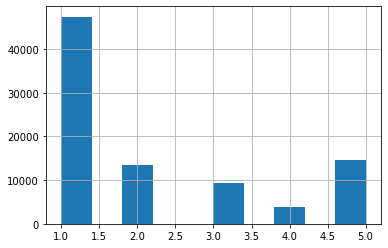

In [3]:
responses_frame.rating_grade.hist();

In [4]:
responses_frame['label'] = np.nan
responses_frame['label'][responses_frame.rating_grade == 1] = 0
responses_frame['label'][responses_frame.rating_grade == 5] = 1

/home/dmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(62100, 4)

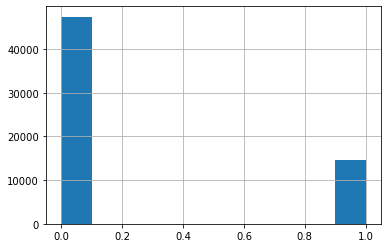

In [5]:
responses_frame = responses_frame[~responses_frame.label.isna()]
responses_frame.label.hist();
responses_frame.shape

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    responses_frame.topic_text, responses_frame.label, test_size=0.25, random_state=42)

## Baseline

In [58]:
clf = Pipeline([
    ('vect', CountVectorizer(analyzer = 'char', ngram_range={1,2})),
    ('clf', RandomForestClassifier()),
])

clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer='char', ngram_range={1, 2})),
                ('clf', RandomForestClassifier())])

In [9]:
X_t = X_test[~X_test.isna()]
y_test = y_test[~X_test.isna()]

In [69]:
predictions = clf.predict(X_t)

Precision:   0.89
Recall:   0.70
F1-measure:   0.74
Accuracy:   0.85
              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91     11805
         1.0       0.94      0.41      0.57      3719

    accuracy                           0.85     15524
   macro avg       0.89      0.70      0.74     15524
weighted avg       0.87      0.85      0.83     15524



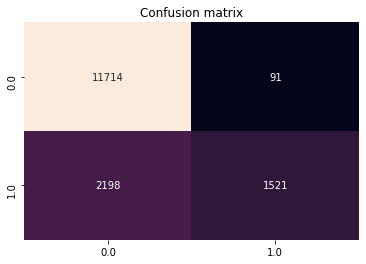

In [70]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))
labels = clf.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [72]:
%%time
clf = Pipeline([
    ('vect', CountVectorizer(analyzer = 'char', ngram_range={1,3})),
    ('clf', RandomForestClassifier()),
])

clf.fit(X_train, y_train)
predictions = clf.predict(X_t)

CPU times: user 11min 35s, sys: 4.19 s, total: 11min 39s
Wall time: 11min 41s


Precision:   0.92
Recall:   0.75
F1-measure:   0.80
Accuracy:   0.88
              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93     11805
         1.0       0.97      0.51      0.67      3719

    accuracy                           0.88     15524
   macro avg       0.92      0.75      0.80     15524
weighted avg       0.89      0.88      0.86     15524



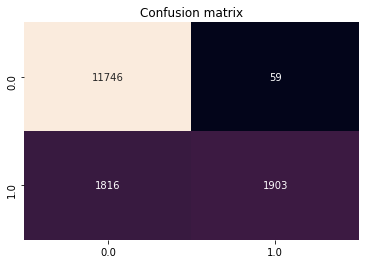

In [73]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))
labels = clf.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

Качество модели с триграммами увеличилось!

In [93]:
%%time
clf = Pipeline([ 
    ('vect', CountVectorizer(analyzer = 'char', ngram_range={1,3})), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD(n_components=30, n_iter=7)), 
    ('clf', RandomForestClassifier())
])
clf.fit(X_train, y_train)
predictions = clf.predict(X_t)

CPU times: user 3min 56s, sys: 2.56 s, total: 3min 59s
Wall time: 3min 46s


Precision:   0.85
Recall:   0.72
F1-measure:   0.76
Accuracy:   0.85
              precision    recall  f1-score   support

         0.0       0.85      0.97      0.91     11805
         1.0       0.85      0.47      0.60      3719

    accuracy                           0.85     15524
   macro avg       0.85      0.72      0.76     15524
weighted avg       0.85      0.85      0.84     15524



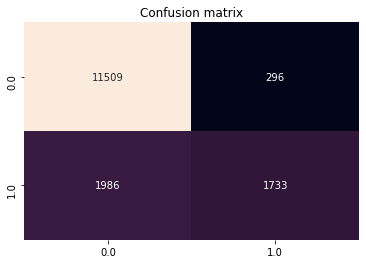

In [94]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))
labels = clf.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [10]:
%%time
clf = Pipeline([ 
    ('vect', CountVectorizer(analyzer = 'char', ngram_range={1,3})), 
    #('tfidf', TfidfTransformer()), 
    ('tm', LatentDirichletAllocation(n_components=30, n_jobs=4)), 
    ('clf', RandomForestClassifier())
])
clf.fit(X_train, y_train)
predictions = clf.predict(X_t)


CPU times: user 2min 43s, sys: 8.01 s, total: 2min 51s
Wall time: 43min 9s


Precision:   0.90
Recall:   0.85
F1-measure:   0.87
Accuracy:   0.91
              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94     11805
         1.0       0.88      0.74      0.80      3719

    accuracy                           0.91     15524
   macro avg       0.90      0.85      0.87     15524
weighted avg       0.91      0.91      0.91     15524



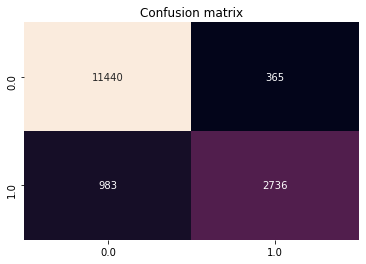

In [11]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))
labels = clf.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

baseline биграммы F1-measure:   0.74
добавили триграммы F1-measure:   0.80
сингулярное разложение F1-measure:   0.76
LDA F1-measure:   0.87

Лучший результат достигается с добавлением триграмм и тематических моделей LDA.
LDA позволяет извлекать из текста наболее значимые признаки для классификации